## Clustering on RandomTreesEmbedding Outputs with Modified Distance Metrics

This demonstration is inspired by the Sparse Projection Oblique Randomer Forest(SPORF) package. 

Distance is an important concept in clustering and other machine learning tasks that gives us an intuitive sense of the similarity 
between samples. This example shows how can we generate different distance metrics from the tree structure info of Random Tree Embedding 
and use these distance metrics to complete various tasks. In this example, we will use them to do clustering. 

In [1]:
from sklearn import tree
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

The distances between two samples i and j can be defined as: 

1) the depth of the nearest common ancestor of the leaf nodes sample i and j land into (take the reciprocal to make it a distance);


In [26]:
def NCA(forest, samples):
    
    n_sample = samples.shape[0]
    d = np.zeros([n_sample, n_sample])
    n_estimator = len(forest)

    for k in range(n_estimator):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
    
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                d[i, j] = d[i, j]+(path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
            

    d = d / n_estimator
    d_Nearest_Common_Ancestor = [1/x for x in d]
    
    return d_Nearest_Common_Ancestor


2) the length of the shortest path of the leaf nodes sample i and j land into; 


In [3]:
def SP(forest, samples): 
    
    n_sample = samples.shape[0]
    d = np.zeros([n_sample, n_sample])
    n_estimator = len(forest)
    
    for k in range(n_estimator):
    
        tree = forest[k]
    
        path = tree.decision_path(samples).todense()
        
        for i in range(n_sample):
            for j in range(n_sample):
                sample_ids = [i, j]
                splitting_depth = (path[sample_ids].sum(axis=0) == len(sample_ids)).sum()
                depth_i = (path[[i, i]].sum(axis=0) == len(sample_ids)).sum()
                depth_j = (path[[j, j]].sum(axis=0) == len(sample_ids)).sum()
                d[i, j] = d[i, j]+depth_i+depth_j-2*splitting_depth

    d_shortest_path = d / n_estimator
    
    return d_shortest_path


3) the probability of sample i and j landing into the same lead node(take 1 minus the value to make it a distance). 


In [4]:
def PM(clf, samples): 
    
    n_sample = samples.shape[0]
    Y = clf.transform(samples)
    prob = np.zeros([n_sample, n_sample])
    
    for i in range(n_sample):
        for j in range(n_sample):
            leaf_i = Y[i, :]
            leaf_j = Y[j, :]
            p = leaf_i.dot(leaf_j.transpose()).todense()
            prob[i, j] = p[0, 0]

    prob = 1 - prob / Y.shape[1]
    
    return prob

To demonstrate the algorithm and compare the performance of the three distance metrics, we firstly generate four differently shaped datasets. The shapes of the datasets are from the "Comparing different clustering algorithms on toy datasets" of scikit-learn. 

Text(0.5,1,'Bars')

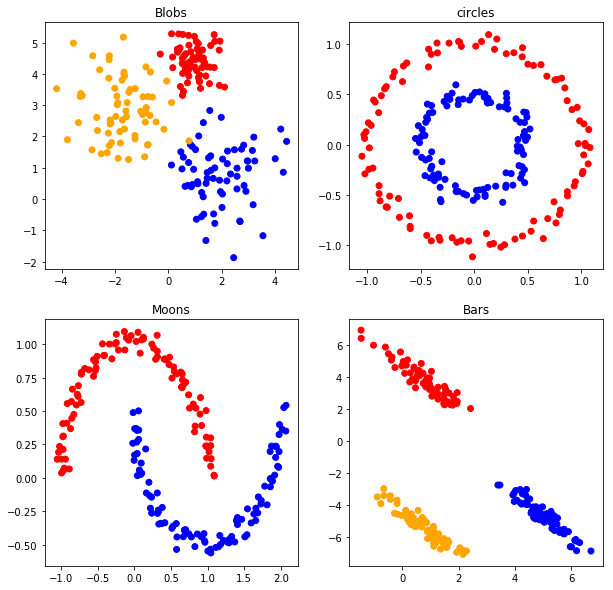

In [74]:
# generate blobs, circles and moons

n_sample = 200

sample_blobs, label_blobs = datasets.make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=[0.5, 1, 1], 
                   center_box=(-10.0, 10.0), shuffle=False, random_state=0)
sample_circles, label_circles = datasets.make_circles(n_samples=n_sample, factor=.5, noise=.05, random_state=1, shuffle=False)
sample_moons, label_moons = datasets.make_moons(n_samples=n_sample, noise=.05, random_state=0, shuffle=False)

# generate bars
sample_bars, label_bars = datasets.make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=1, 
                   center_box=(-12.0, 12.0), shuffle=False, random_state=8)
trans = [[0.6, -0.6], [-0.4, 0.8]]
sample_bars = np.dot(sample_bars, trans)

# make scatter plots
colors = np.array(['red', 'blue', 'orange'])

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(sample_blobs[:, 0], sample_blobs[:, 1], color=colors[label_blobs])
plt.title('Blobs')
plt.subplot(2, 2, 2)
plt.scatter(sample_circles[:, 0], sample_circles[:, 1], color=colors[label_circles])
plt.title('circles')
plt.subplot(2, 2, 3)
plt.scatter(sample_moons[:, 0], sample_moons[:, 1], color=colors[label_moons])
plt.title('Moons')
plt.subplot(2, 2, 4)
plt.scatter(sample_bars[:, 0], sample_bars[:, 1], color=colors[label_bars])
plt.title('Bars')

In [78]:
# organize the datasets
data = [(sample_blobs, label_blobs, {'n_clusters': 3, 'affinity': 'precomputed', 'linkage': 'complete'}), 
       (sample_circles, label_circles, {'n_clusters': 2, 'affinity': 'precomputed', 'linkage': 'single'}), 
       (sample_moons, label_moons, {'n_clusters': 2, 'affinity': 'precomputed', 'linkage': 'single'}), 
       (sample_bars, label_bars, {'n_clusters': 3, 'affinity': 'precomputed', 'linkage': 'average'})]

Calculate and cluster on the different distance metrics

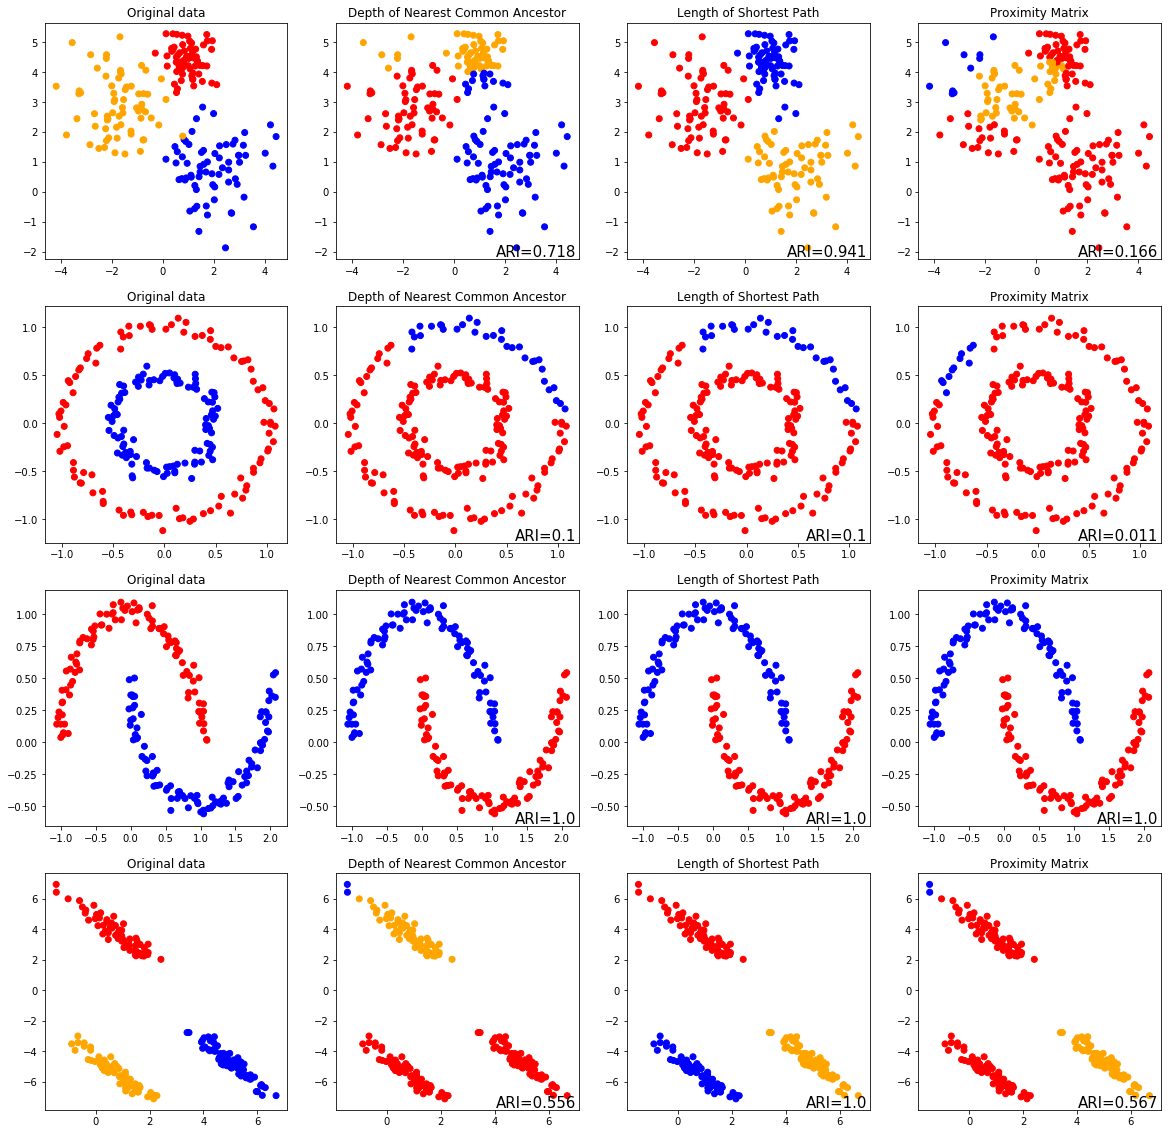

In [79]:
plt.figure(figsize=(20, 20))

for i, (samples, labels, params) in enumerate(data): 
    
    # train random trees embedding classifier
    clf = RandomTreesEmbedding(n_estimators=50, random_state=0, max_depth=5)
    clf.fit(samples)
    forest = clf.estimators_
    
    # compute the distance metrics
    d_nca= NCA(forest, samples)
    d_sp = SP(forest, samples)
    d_prob = PM(clf, samples)
    
    # use agglomerative clustering to cluster the outputs
    cluster = AgglomerativeClustering()
    cluster.n_clusters = params['n_clusters']
    cluster.affinity = params['affinity']
    cluster.linkage = params['linkage']
    
    pred_NCA = cluster.fit_predict(d_nca)
    score_NCA = adjusted_rand_score(labels, pred_NCA)
    pred_SP = cluster.fit_predict(d_sp)
    score_SP = adjusted_rand_score(labels, pred_SP)
    pred_PM = cluster.fit_predict(d_prob)
    score_PM = adjusted_rand_score(labels, pred_PM)
    
    plt.subplot(4, 4, i*4+1)
    plt.scatter(samples[:, 0], samples[:, 1], color=colors[labels])
    plt.title('Original data')
    plt.subplot(4, 4, i*4+2)
    plt.scatter(samples[:, 0], samples[:, 1], color=colors[pred_NCA])
    plt.title('Depth of Nearest Common Ancestor')
    plt.text(0.99, 0.01, 'ARI='+str(round(score_NCA, 3)), 
             transform=plt.gca().transAxes, size=15, horizontalalignment='right')
    plt.subplot(4, 4, i*4+3)
    plt.scatter(samples[:, 0], samples[:, 1], color=colors[pred_SP])
    plt.title('Length of Shortest Path')
    plt.text(0.99, 0.01, 'ARI='+str(round(score_SP, 3)), 
             transform=plt.gca().transAxes, size=15, horizontalalignment='right')
    plt.subplot(4, 4, i*4+4)
    plt.scatter(samples[:, 0], samples[:, 1], color=colors[pred_PM])
    plt.title('Proximity Matrix')
    plt.text(0.99, 0.01, 'ARI='+str(round(score_PM, 3)), 
             transform=plt.gca().transAxes, size=15, horizontalalignment='right')